## Assign Common ID Between Datasets

In [ ]:
from IPython.display import clear_output

Weather stations after Alberta + bounds filter: 651
rainbow length 311


/tmp/ipykernel_40286/3283223193.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('gist_ncar', n)


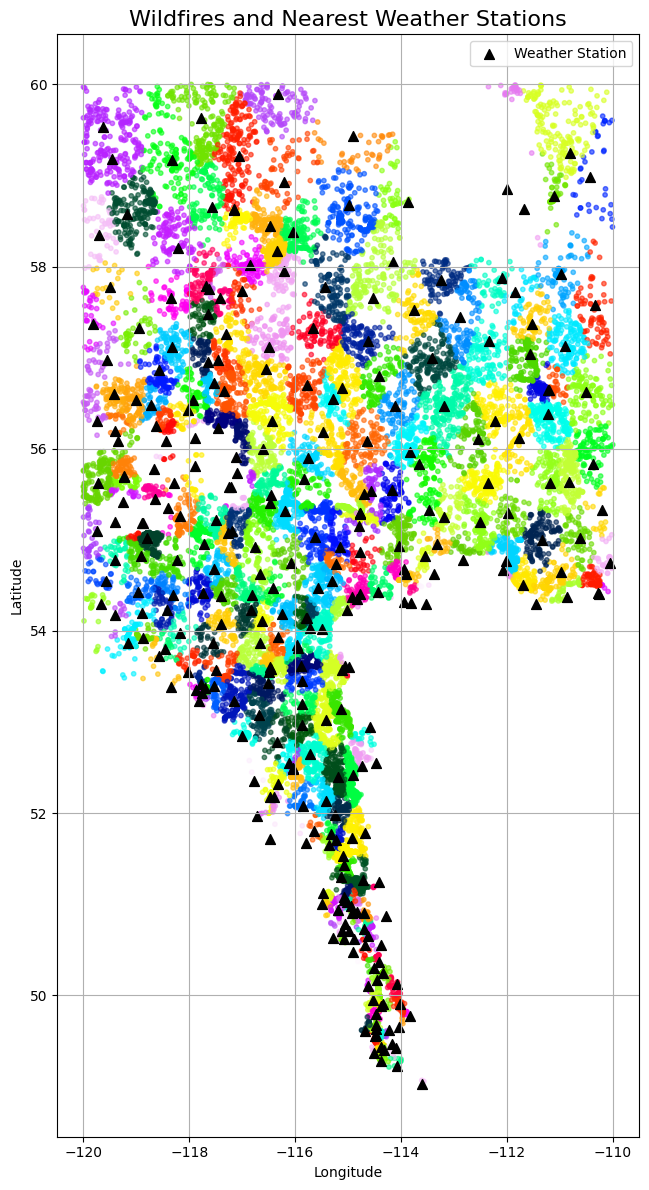

{'1814': 'AURORA LO', '1815': 'BASELINE LO', '1822': 'BLACKSTONE LO', '1823': 'BRAZEAU LO', '1848': 'CLEARWATER', '27260': 'ELK RIVER AFS', '8712': 'ROCKY MTN HOUSE (AUT)', '1967': 'ST LINA', '30643': 'VIOLET GROVE CS', '2017': 'WINFIELD', '1799': 'HORBURG', '55338': 'PIBROCH AGCM', '8723': 'COALCAMP CREEK', '43561': 'LEEDALE AGDM', '2108': 'LOBSTICK AUBUCHON', '10105': 'SUNDRE A', '8753': 'BEAUVAIS PARK', '42443': 'COCHRANE BIGHILL CREEK', '2231': 'CONNELLY CREEK', '31089': 'COWLEY TANNER', '2239': 'FIVE MILE CREEK', '48468': 'PRIDDIS OBSERVATORY', '43363': 'WILDCAT HILLS', '2363': 'BALDY LO', '27295': 'BARRIER LAKE', '2366': 'BEAVER MINES', '2365': 'BIGHORN DAM', '2368': 'BLUEHILL LO', '10222': 'BOW VALLEY', '8924': 'BURNS CREEK', '2375': 'CARBONDALE LO', '2377': 'CASTLE', '2379': 'CLINE LO', '8914': 'COMPRESSION RIDGE', '8724': 'COX HILL', '10690': 'CROWSNEST CREEK', '10890': 'CROWSNEST', '2386': 'ELBOW RS', '8825': 'FALLEN TIMBER', '8824': 'FORGET ME NOT MOUNTAIN', '27716': "GOAT'S

In [117]:
# Re-import required libraries after code execution environment reset
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.cm as cm
import matplotlib.colors as mcolors

alberta_bounds = {
    "lat_min": 48.9,
    "lat_max": 60.0,
    "lon_min": -120.0,
    "lon_max": -110.0
}


# Define the class again
class WildfireWeatherAnalysis:
    def __init__(self, wildfire_file, weather_file):
        self.wildfire_file = wildfire_file
        self.weather_file = weather_file
        self.df = None
        self.clustered_gdf = None
        self.weather_gdf = None

    def load_data(self):
        # Load wildfire data
        if self.wildfire_file.endswith('.xlsx'):
            excel_file = pd.ExcelFile(self.wildfire_file)
            self.df = pd.read_excel(excel_file, sheet_name="2006-2024")
        elif self.wildfire_file.endswith('.csv'):
            self.df = pd.read_csv(self.wildfire_file)
        else:
            raise ValueError("Unsupported wildfire file format")

        # Load weather station data
        weather_df = pd.read_csv(self.weather_file, skiprows=0, quotechar='"')

        weather_df = weather_df[weather_df["Province"].str.upper() == "ALBERTA"]

        # Analyze

        import numpy as np

        # Ensure types match
        weather_df["Station ID"] = weather_df["Station ID"].astype(str)
        kept = ['1977', '48550', '8884', '2823', '48949', '2586', '46827', '10225', '2511', '2613', '51497', '27031', '2663', '41785', '51377', '2605', '2553', '51500', '50920', '27652', '2767', '30726', '2693', '10864', '1805', '2770', '2797', '2471', '2502', '10105', '2479', '2788', '2704', '27212', '46447', '27037', '32455', '2402', '2173', '42727', '43151', '53998', '8893', '2416', '42443', '8838', '2323', '26888', '46910', '9010', '32333', '2745', '2750', '2732', '1823', '27713', '1984', '2395', '2685', '2301', '52258', '2593', '50757', '2489', '2102', '27219', '55538', '27825', '45887', '2656', '43581', '10689', '8924', '6853', '53078', '53100', '2570', '8824', '27455', '47090', '2407', '2578', '2562', '50149', '47748', '8819', '47073', '50940', '2604', '1898', '47147', '27261', '31027', '2368', '42726', '46127', '2339', '27655', '2564', '2460', '46847', '32394', '2677', '2134', '2517', '32255', '51498', '46132', '51578', '1920', '1953', '2722', '1825', '2626', '27715', '10907', '51858', '2690', '51422', '1896', '53098', '27041', '2001', '32149', '50622', '2092', '8804', '2764', '2700', '46811', '2431', '2169', '27658', '8857', '2454', '53999', '2409', '46787', '2657', '50937', '27828', '1884', '2556', '44266', '43147', '51838', '32256', '1839', '2274', '55338', '27213', '46851', '55018', '31608', '2423', '50129', '2086', '2814', '2596', '51444', '42728', '54358', '45748', '45927', '8859', '47107', '2377', '32253', '31411', '31447', '50939', '32454', '2072', '2694', '46849', '31409', '46729', '2648', '1814', '2432', '2519', '8918', '50922', '2224', '2103', '47068', '2795', '2635', '45767', '2050', '2528', '45907', '1881', '8712', '30643', '41784', '2405', '2273', '8830', '46467', '2621', '9609', '10708', '2231', '2765', '2829', '50918', '50921', '31427', '32458', '2538', '31468', '6860', '2731', '2737', '43783', '47089', '2542', '2832', '27650', '42731', '2790', '2590', '2144', '50623', '1799', '2624', '30495', '46468', '2386', '2594', '1967', '8837', '2778', '1835', '47076', '46128', '2440', '53738', '32456', '47087', '2601', '2113', '2746', '1812', '2016', '2597', '1857', '47070', '2457', '46914', '32274', '46130', '46129', '8872', '2025', '2174', '50128', '30641', '2809', '2482', '50028', '30543', '2347', '2500', '54478', '47108', '1935', '10104', '47071', '1915', '8900', '29926', '46807', '2813', '2680', '47128', '2819', '49949', '2400', '30055', '53099', '51499', '2666', '49968', '10906', '42724', '2108', '2655', '2461', '49268', '2567', '42703', '27653', '2392', '2668', '46852', '49490', '31207', '46913', '27492', '2112', '2425', '31089', '2263', '2467', '8917', '2503', '46810', '2523', '2504', '55419', '53718', '2312', '2632', '2573', '46734', '47747', '2654', '31408', '41757', '2276', '49048', '46470', '2017', '51840', '46912', '2689', '2757', '50311', '8753', '2150', '2515', '2255', '2485', '46927', '53918', '2462', '2141', '2258', '2219', '50917', '43150', '2803', '52982', '9015', '46867', '2429', '10222', '2658', '1801', '47077', '2068', '2459', '45727', '2411', '27656', '2684', '9611', '32231', '2492', '46469', '10725', '46327', '2227', '27216', '27295', '2712', '1822', '44746', '10665', '50938', '32459', '32232', '46848', '45947', '10915', '26971', '2438', '8895', '46131', '42729', '32257', '43148', '47047', '2634', '2721', '2821', '55418', '2171', '8723', '43580', '43363', '49369', '30310', '45847', '47767', '2122', '51898', '2521', '2510', '2675', '2783', '2782', '2539', '31410', '51501', '2366', '43164', '46732', '46808', '2755', '48948', '30669', '2762', '2239', '46907', '31412', '45749', '2375', '32313', '53198', '2628', '2718', '2572', '2794', '27200', '2641', '27214', '2735', '10930', '45647', '30907', '27793', '1904', '49948', '27260', '47110', '1990', '2205', '42730', '2481', '46850', '45867', '2701', '2513', '2804', '2673', '46767', '2667', '43561', '41783', '2452', '2811', '2404', '50777', '10223', '27030', '27029', '2363', '47075', '48975', '2761', '42283', '2736', '1868', '27262', '2800', '27217', '2719', '2078', '27716', '2592', '2120', '45948', '27845', '29633', '2379', '10700', '2332', '2140', '10928', '10793', '8791', '32395', '8856', '43149', '42164', '2247', '49368', '30347', '46887', '9410', '47072', '46730', '2493', '2218', '1865', '31588', '2486', '2614', '46731', '2279', '2537', '1958', '2674', '45747', '42163', '31469', '2295', '8916', '2410', '2393', '52358', '32273', '52200', '46909', '1828', '2793', '31288', '46471', '46809', '1848', '26870', '27040', '1815', '2315', '9604', '47067', '51841', '2781', '2639', '10183', '1859', '51440', '10693', '47074', '54718', '32461', '27038', '1873', '49928', '54000', '42725', '27036', '50919', '2180', '27018', '46928', '48468', '8825', '47069', '10889', '47727', '52459', '8915', '1886', '2084', '46908', '55478', '10932', '10691', '27211', '47787', '29573', '49050', '2265', '27378', '32460', '8920', '2508', '31528', '31414', '10978', '1872', '30433', '2580', '2123', '2830', '46911', '6865', '1974', '1870', '27199', '50923', '2650', '2622', '8724', '2577', '2145', '49049', '2726', '2490', '43560', '27657', '2545', '47088', '31413', '51839', '51899', '32453', '2739', '2133', '27218', '53358', '46733', '27263', '1829', '51758', '9610', '6854', '2501', '31407', '32230', '52458', '32457', '8919', '2779', '10690', '2396', '1843', '9608', '42723', '26850', '47109', '2561', '47127', '2818', '6863', '2417', '1840', '46812', '2649', '31198', '2806', '52478', '50430', '2543', '10890', '2544', '8855', '27654', '55118', '9436', '2740', '55098', '27331', '51502', '32254', '46853', '8851', '2365', '2522', '32433', '8914']
        weather_df = weather_df[weather_df['Station ID'].astype(str).isin(kept)]

        weather_df = weather_df.dropna(subset=["Latitude (Decimal Degrees)", "Longitude (Decimal Degrees)"])
        weather_df = weather_df[
            (weather_df["Province"].str.upper() == "ALBERTA") &
            (weather_df["Latitude (Decimal Degrees)"].between(alberta_bounds["lat_min"], alberta_bounds["lat_max"])) &
            (weather_df["Longitude (Decimal Degrees)"].between(alberta_bounds["lon_min"], alberta_bounds["lon_max"]))
        ]
        print("Weather stations after Alberta + bounds filter:", len(weather_df))


        self.weather_gdf = gpd.GeoDataFrame(
            weather_df,
            geometry=gpd.points_from_xy(weather_df["Longitude (Decimal Degrees)"], weather_df["Latitude (Decimal Degrees)"]),
            crs="EPSG:4326"
        )

        self.cluster_wildfires_analyze()

        self.weather_gdf = self.weather_gdf[self.weather_gdf["Station ID"].isin(self.df["Station ID"].to_list())]

        # self.weather_gdf = gpd.GeoDataFrame(
        #     weather_df,
        #     geometry=gpd.points_from_xy(weather_df["Longitude (Decimal Degrees)"], weather_df["Latitude (Decimal Degrees)"]),
        #     crs="EPSG:4326"
        # )



    def cluster_wildfires(self, n_clusters=100):
        coords = self.df[['LATITUDE', 'LONGITUDE']].dropna()
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        coords['CLUSTER'] = kmeans.fit_predict(coords)
        
        self.clustered_gdf = gpd.GeoDataFrame(
            coords,
            geometry=gpd.points_from_xy(coords['LONGITUDE'], coords['LATITUDE']),
            crs="EPSG:4326"
        )

    # def plot_clusters(self):
    #     fig, ax = plt.subplots(figsize=(15, 12))
    #     self.clustered_gdf.plot(ax=ax, column='CLUSTER', categorical=True, legend=False, markersize=10, alpha=0.6)
    #     ax.set_title("KMeans Clustering of Wildfire Locations (100 Clusters)", fontsize=16)
    #     ax.set_xlabel("Longitude")
    #     ax.set_ylabel("Latitude")
    #     plt.grid(True)
    #     plt.tight_layout()
    #     plt.show()

    def plot_clusters_with_weather(self):
        fig, ax = plt.subplots(figsize=(15, 12))

        # Use same color mapping logic
        station_ids = self.clustered_gdf['Station ID'].astype(str).unique()
        n = len(station_ids)
        print("rainbow length", n)
        cmap = cm.get_cmap('gist_ncar', n)
        color_map = {station: mcolors.rgb2hex(cmap(i)) for i, station in enumerate(station_ids)}
        self.clustered_gdf['color'] = self.clustered_gdf['Station ID'].astype(str).map(color_map)

        self.clustered_gdf.plot(ax=ax, color=self.clustered_gdf['color'], markersize=10, alpha=0.6)
        self.weather_gdf.plot(ax=ax, color='black', marker='^', label='Weather Station', markersize=50)

        ax.set_title("Wildfires and Nearest Weather Stations", fontsize=16)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        return station_ids


    def cluster_wildfires_analyze(self):
        # Ensure wildfire locations are valid
        wildfire_coords = self.df[['LATITUDE', 'LONGITUDE']].dropna().copy()
        
        # Get weather station coordinates and their Station IDs
        weather_coords = self.weather_gdf[['Latitude (Decimal Degrees)', 'Longitude (Decimal Degrees)']].to_numpy()
        station_ids = self.weather_gdf['Station ID'].to_numpy()
        
        # Wildfire coordinates
        fire_coords = wildfire_coords[['LATITUDE', 'LONGITUDE']].to_numpy()
        
        # Find closest weather station index and distances
        closest_indices, _ = pairwise_distances_argmin_min(fire_coords, weather_coords)

        # Map each wildfire to its nearest station ID
        wildfire_coords['Station ID'] = station_ids[closest_indices]
        
        # Merge the cluster assignment back into original df
        self.df = self.df.merge(wildfire_coords[['LATITUDE', 'LONGITUDE', 'Station ID']], 
                                on=['LATITUDE', 'LONGITUDE'], 
                                how='left')
        
        # Create GeoDataFrame for plotting
        self.clustered_gdf = gpd.GeoDataFrame(
            wildfire_coords,
            geometry=gpd.points_from_xy(wildfire_coords['LONGITUDE'], wildfire_coords['LATITUDE']),
            crs="EPSG:4326"
        )

    def lookup_station_names(self, list_of_id):
        df = self.weather_gdf.copy()
        df = df[["Name", "Station ID"]].copy()

        
        # Filter to only those in the provided list
        matched = df[df['Station ID'].isin(list_of_id)]
        
        # Return as a dictionary {id: name}
        return dict(zip(matched['Station ID'], matched['Name'])), dict(zip(matched['Name'], matched['Station ID'])),



# Instantiate and run the analysis
analysis = WildfireWeatherAnalysis(
    wildfire_file="fp-historical-wildfire-data-2006-2024.csv",
    weather_file="StationInventoryEN.csv"
)
analysis.load_data()

# analysis.plot_clusters_with_weather()
filtered_stationID = analysis.plot_clusters_with_weather()
id2name_lookup, name2id_lookup = analysis.lookup_station_names(filtered_stationID)
print(id2name_lookup, name2id_lookup)
filtered_stationName = []
for id in filtered_stationID:
    filtered_stationName.append(id2name_lookup.get(id))
print(filtered_stationName)


### 0. Data Loading: Collected Data Covereage into Single CSV for weather and lightning datasets
- Weather Satation Dataset: multiple csv, each featuring station ID and which Year it reports
- Lightning Dataset: multiple csv, each featuring station ID and which Year it reports.

In [ ]:
import os
import shutil
import pandas as pd

FIRE_RECORD = "fp-historical-wildfire-data-2006-2024.csv"
WEATHER_STATION_DIRECTORY = "/mnt/d/446Project/WeatherTransformer/data_processing/raw_data/keep/"
LIGHTNING_DIRECTORY = "/mnt/d/446Project/WeatherTransformer/data_processing/raw_data/lightning_data/"

### 1. Aggregate CSV
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

def load_csvs_into_single_file_multithread(
    source_directory, 
    output_file="all_combined.csv", 
    skip_lines=0, 
    thread_count=4
):
    # list all .csv paths
    csv_files = []
    for root, _, files in os.walk(source_directory):
        for file in files:
            if file.lower().endswith(".csv"):
                csv_files.append(os.path.join(root, file))
    
    total_files = len(csv_files)
    if total_files == 0:
        print("No CSV files found. No output created.")
        return None
    
    # Worker: function read a single CSV
    def read_csv_file(file_path, skip):
        """
        Reads a CSV file with optional skiprows, returning the DataFrame.
        Raises any exception to be handled by caller.
        """
        return pd.read_csv(file_path, encoding='utf-8', low_memory=False, skiprows=skip)
    
    # ThreadPoolExecutor to read files in parallel
    dfs = []
    success_count = 0
    
    print(f"Found {total_files} CSV files. Using {thread_count} thread(s) for parallel loading...\n")
    with ThreadPoolExecutor(max_workers=thread_count) as executor:
        # Submit each file to the pool
        future_to_path = {
            executor.submit(read_csv_file, fpath, skip_lines): fpath
            for fpath in csv_files
        }
        
        # Collect results as they complete
        for future in as_completed(future_to_path):
            file_path = future_to_path[future]
            try:
                df = future.result()  # If an exception occurred, it raises here
                dfs.append(df)
                success_count += 1
                print(f"[Loaded] {file_path} ({success_count}/{total_files})")
            except Exception as e:
                print(f"[Failed] {file_path} — Error: {e}")
    
    # 3. If we have at least one loaded DataFrame, combine them
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        combined_df.to_csv(output_file, index=False)
        
        print(f"\nSuccessfully loaded [{success_count}/{total_files}] CSV files.")
        print(f"Combined DataFrame has {combined_df.shape[0]} rows and {combined_df.shape[1]} columns.")
        print(f"Saved merged output to '{output_file}'.")
        return combined_df
    else:
        print("\nNo CSV files loaded successfully. No output created.")
        return None


# Change thread_count to best match your system's capabilities or I/O constraints
weather_df = load_csvs_into_single_file_multithread(
    source_directory=WEATHER_STATION_DIRECTORY,
    output_file="all_combined_weatherstation.csv",
    skip_lines=0,
    thread_count=40
)
lightning_combined = load_csvs_into_single_file_multithread(
    source_directory=LIGHTNING_DIRECTORY,
    output_file="all_combined_lightning.csv",
    skip_lines=2,
    thread_count=40
)


# weather_df = load_csvs_into_single_file(WEATHER_STATION_DIRECTORY, "all_combined_weatherstation.csv")
# lightning_df = load_csvs_into_single_file(LIGHTNING_DIRECTORY, "all_combined_lightning.csv", skip_lines = 2)

#### Null Test

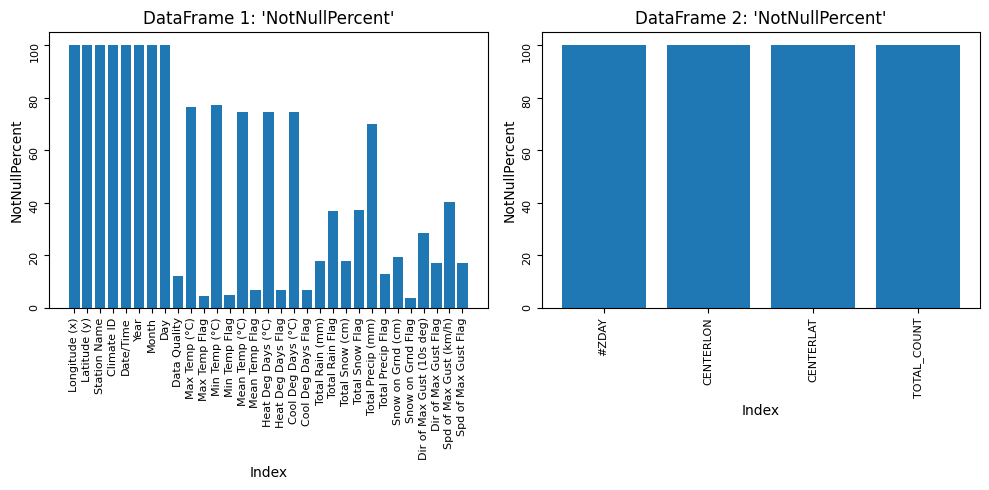

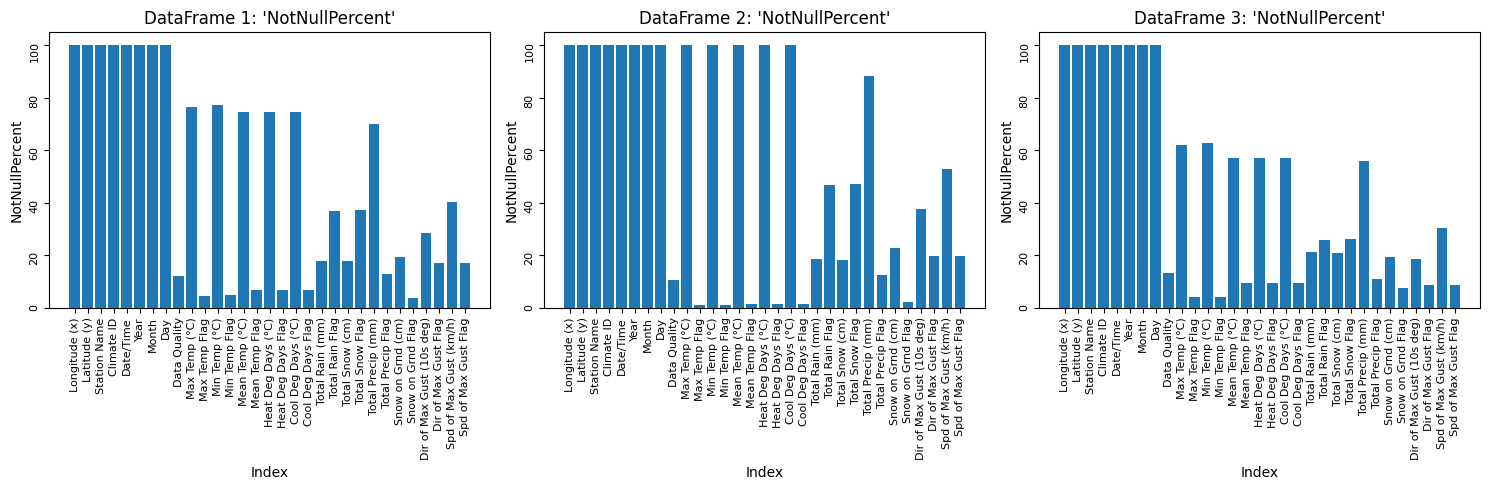

         Longitude (x)  Latitude (y)      Station Name Climate ID   Date/Time  \
1133           -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2014-02-07   
1171           -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2014-03-17   
1426           -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2014-11-27   
1428           -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2014-11-29   
1429           -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2014-11-30   
...                ...           ...               ...        ...         ...   
2024483        -114.22         51.08         COP UPPER    3031875  2016-06-19   
2024494        -114.22         51.08         COP UPPER    3031875  2016-06-30   
2024504        -114.22         51.08         COP UPPER    3031875  2016-07-10   
2024505        -114.22         51.08         COP UPPER    3031875  2016-07-11   
2024506        -114.22         51.08         COP UPPER    3031875  2016-07-12   

         Year  Month  Day D

In [119]:
import pandas as pd
import matplotlib.pyplot as plt


def column_empty_report(df):
    """
    Returns a DataFrame summarizing how many rows in each column are empty 
    (NaN) and the percentage of empties out of total rows.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame to analyze.
    
    Returns
    -------
    pd.DataFrame
        A table with columns:
            'ColumnName'   : The original column name
            'EmptyCount'   : Number of rows that are NaN in this column
            'EmptyPercent' : Percentage of rows that are NaN (0.00 to 100.00)
            'Report'       : String showing both the count and percentage
    """
    total_rows = len(df)
    results = []

    for col in df.columns:
        # Count how many rows are NaN in this column
        empty_count = df[col].isna().sum()
        
        # Calculate percentage (avoid divide-by-zero if DF is empty)
        if total_rows > 0:
            empty_percent = (empty_count / total_rows) * 100
        else:
            empty_percent = 0.0
        
        results.append({
            "ColumnName": col,
            "EmptyCount": empty_count,
            "EmptyPercent": round(empty_percent, 2)
        })
        
    # Return as a DataFrame
    return pd.DataFrame(results)

def plot_two_dataframes(dfs):

    n = len(dfs)
    if n == 0:
        print("No DataFrames to plot.")
        return
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(5*n, 5), sharey=False)

    for i, df in enumerate(dfs):
        df["NotNullPercent"] = 100 - df["EmptyPercent"]
        ax = axes[i]  # Subplot axis
        ax.bar(df["ColumnName"], df["NotNullPercent"])
        ax.set_title(f"DataFrame {i+1}: '{"NotNullPercent"}'")
        ax.set_xlabel("Index")
        ax.set_ylabel("NotNullPercent")
        ax.tick_params(labelrotation=90, labelsize=8)
    
    # Tight layout so x-labels don't get cut off
    plt.tight_layout()
    
    # Display
    plt.show()


# Load only for the first time:
# weather_df = pd.read_csv("all_combined_weatherstation.csv", encoding='utf-8', low_memory=False, skiprows=0)
# lightning_df = pd.read_csv("all_combined_lightning.csv", encoding='utf-8', low_memory=False, skiprows=0)

weather_df_validity = column_empty_report(weather_df)
lightning_df_validity = column_empty_report(lightning_df)
# print("weather_df_validity: \n", weather_df_validity)
# print("lightning_df_validity: \n", lightning_df_validity)
plot_two_dataframes([weather_df_validity, lightning_df_validity])
df_with_wind = weather_df[weather_df["Spd of Max Gust (km/h)"].notnull()]
df_without_wind = weather_df[weather_df["Spd of Max Gust (km/h)"].isnull()]
df_without_tmp = weather_df[weather_df["Mean Temp (°C)"].isnull()]
df_without_tmp = df_without_tmp[df_without_tmp["Max Temp (°C)"].isnull()]
df_without_tmp = df_without_tmp[df_without_tmp["Min Temp (°C)"].isnull()]

df_with_tmp = weather_df[weather_df["Mean Temp (°C)"].notnull()]
df_with_tmp = df_with_tmp[df_with_tmp["Max Temp (°C)"].notnull()]
df_with_tmp = df_with_tmp[df_with_tmp["Min Temp (°C)"].notnull()]

df_filtered_tmp = weather_df[weather_df["Station Name"].isin(filtered_stationName)]
plot_two_dataframes([column_empty_report(weather_df), column_empty_report(df_with_tmp), column_empty_report(df_filtered_tmp)])
print(df_without_tmp)

         Longitude (x)  Latitude (y)      Station Name Climate ID   Date/Time  \
0              -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2011-01-01   
1              -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2011-01-02   
2              -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2011-01-03   
3              -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2011-01-04   
4              -115.19         50.94  NAKISKA RIDGETOP    305MGFF  2011-01-05   
...                ...           ...               ...        ...         ...   
2022118        -114.47         49.80      VICARY CREEK    305FQKP  2007-12-27   
2022119        -114.47         49.80      VICARY CREEK    305FQKP  2007-12-28   
2022120        -114.47         49.80      VICARY CREEK    305FQKP  2007-12-29   
2022121        -114.47         49.80      VICARY CREEK    305FQKP  2007-12-30   
2022122        -114.47         49.80      VICARY CREEK    305FQKP  2007-12-31   

         Year  Month  Day D

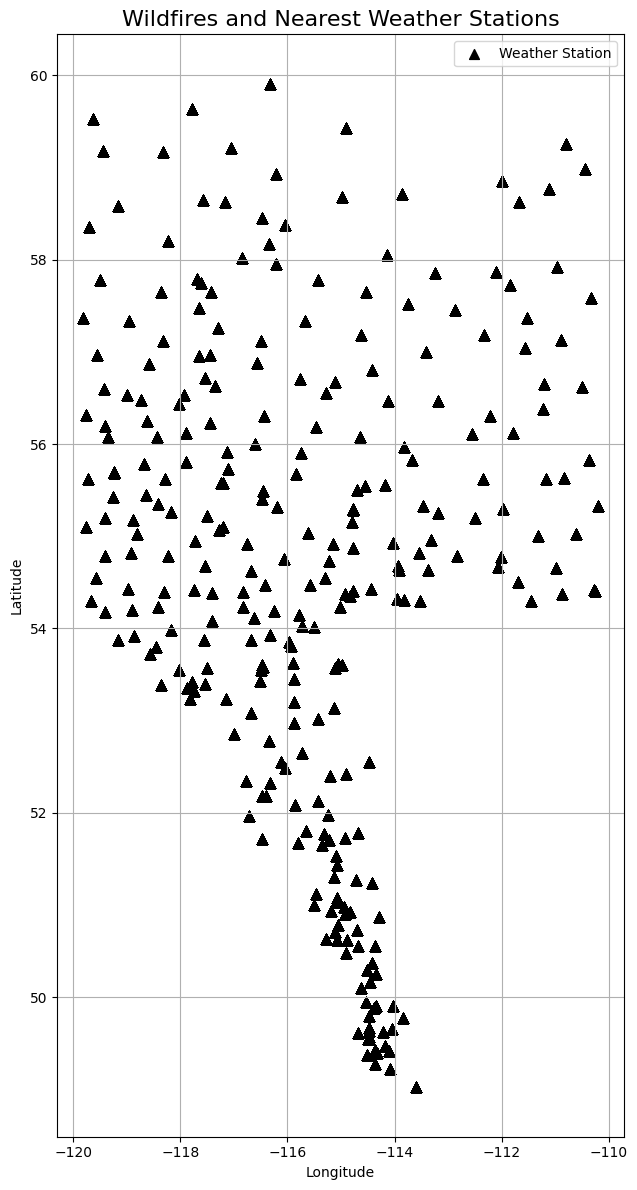

In [121]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def plot_stations(df):
    fig, ax = plt.subplots(figsize=(15, 12))
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["Longitude (x)"], df["Latitude (y)"]),
        crs="EPSG:4326"
    )
    gdf.plot(ax=ax, color='black', marker='^', label='Weather Station', markersize=50)

    ax.set_title("Wildfires and Nearest Weather Stations", fontsize=16)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print(df_filtered_tmp)
plot_stations(df_filtered_tmp)



---
### 1. Data Realization: Assigning Common ID between fire dataset and weather dataset.

Data Source 1: Fire Dataset, ground truth of all exsiting fires of Alberta province, are recorded in high precision Latitude and Longtitude and span the map.
- Latitude and longitute labelling.
- Thousands of fires per year.
- Spanning from 1800 - 2025
- Each represent a ground truth point that the training must predict.

Data Source 2: Government Weather Station Dataset, archive of Canadian Weather station, that collect accurate tempreature and rainfall data instead of weather prediction.
- Latitude and longitute labelling.
- 600 weather stations
- Spanning from 1800 - 2025
- Very few have complete daily data. High Null Rate: 40%

Data Source 3: Daily Lightning Frequency Dataset, arhive of global lightning data with latatude and longtitude labelling.
- Latitude and longitute labelling.
- Millions of lightnings per year.
- Wide Range of Lightning Span, covering almost every location of the country. Data needs to be aggregated statistically or clustered. 

---

### 2. Common ID Problem: There are around 20,000 fires a year, and only 600 weather stations across the Alberta district with accurate recordings., much more fire locations and lightning locations than that the weather station can cover. 

In order to connect exsisting Fire data to weather stations' historical data in Alberta, one must assign a common index system that represent weather condition around the fire location.

1. Clustering Fire Events: To cluster with K-Means clustering where K = Number of DataStation.

2. Closest Neighbour: Identify Regions of Monitoring, associate each Fire Record with a weather station that is closets to it, to reflect the nearby weather data

---

In [124]:
import pandas as pd
# !pip install geopy
from geopy.distance import geodesic

def find_closest_stations(df, input_lat, input_lon, k=3, lat_col='Latitude (y)', lon_col='Longitude (x)'):
    """
    Finds the k closest rows in the DataFrame based on geodesic distance
    to the given latitude and longitude.

    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing weather station data.
    input_lat : float
        Latitude of the input point.
    input_lon : float
        Longitude of the input point.
    k : int
        Number of closest rows to return.
    lat_col : str
        Name of the latitude column in the DataFrame.
    lon_col : str
        Name of the longitude column in the DataFrame.

    Returns:
    --------
    pd.DataFrame
        A new DataFrame with the top k closest rows.
    """
    # Ensure no NaN in lat/lon
    df_valid = df.dropna(subset=[lat_col, lon_col]).copy()

    # Compute geodesic distance row-wise
    df_valid['Distance_km'] = df_valid.apply(
        lambda row: geodesic((input_lat, input_lon), (row[lat_col], row[lon_col])).kilometers,
        axis=1
    )

    # Return top-k closest
    return df_valid.nsmallest(k, 'Distance_km')

# Your input coordinates (somewhere in Alberta, for example)
input_lat = 55.0
input_lon = -116.0

# Find 3 closest stations
closest_rows_df = find_closest_stations(df_filtered_tmp, input_lat, input_lon, k=3)

print(closest_rows_df[['Station Name', 'Latitude (y)', 'Longitude (x)', 'Date/Time', 'Distance_km']])



             Station Name  Latitude (y)  Longitude (x)   Date/Time  \
460966  HOUSE MOUNTAIN LO         55.03        -115.62  2010-01-01   
460967  HOUSE MOUNTAIN LO         55.03        -115.62  2010-01-02   
460968  HOUSE MOUNTAIN LO         55.03        -115.62  2010-01-03   

        Distance_km  
460966     24.53701  
460967     24.53701  
460968     24.53701  
